In [1]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from matplotlib import pyplot as plt
from pathlib import Path
from scipy.spatial.distance import dice
from sklearn.metrics import precision_score, recall_score
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.multitest import multipletests


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)
hexes = [neutral_color, '#FF780A']
cmap = get_continuous_cmap(hexes)


# import data

In [4]:
# read in aligned Prochlorococcus model datasets

datapath = Path('../../data')

pro_ds = xr.open_dataset(datapath / '5-models/pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / '5-models/syn-aligned-models.nc')

pro_ds


<xarray.Dataset>
Dimensions:           (bootstrap: 100, replicate: 3, component: 20,
                       ortholog: 5084, clade: 3, samplename: 76)
Coordinates:
  * bootstrap         (bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * replicate         (replicate) object 'A' 'B' 'C'
  * component         (component) int64 1 2 3 4 5 6 7 8 ... 14 15 16 17 18 19 20
  * ortholog          (ortholog) int64 60000001 60000002 ... 60040287 60040292
  * clade             (clade) object 'HLI' 'HLII' 'LLI'
  * samplename        (samplename) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.N...
Data variables:
    componentweights  (bootstrap, replicate, component) float64 ...
    geneweights       (bootstrap, replicate, component, ortholog) float64 ...
    taxonweights      (bootstrap, replicate, component, clade) float64 ...
    sampleweights     (bootstrap, replicate, component, samplename) float64 ...
    sample            (bootstrap, replicate, samplename) object ...

In [5]:
# read in metadata

sample_df = pd.read_csv(datapath / 'metadata/archive/sample_metadata_merged.csv')

sample_df


,samplename,cruise,year,datetime,latitude,longitude,depth,dataset,samplegroup,timefraction,timeclass,experiment,condition,treatment,timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [6]:
# read in Zinser cluster data

# Table_S1.xls downloaded from Zinser et al., 2008: https://doi.org/10.1371/journal.pone.0005135
zinser_df = pd.read_excel(datapath / '8-interpretation/Table_S1.xls', skiprows=3, usecols='A:K').rename(
    columns={'Gene or region':'legacy_gene_id', 'Cluster':'zinser_cluster_id', 'Cluster membership score': 'zinser_score'}
)

# MED4_cycog6_table.tsv from Paul's Blast analysis (scripts in directory)
# NOTE that PMM1938, PMM1955, PMM1404, and PMM2016 did not have any CyCOG hit, likely due to differences in gene calling software
cycog_map_df = pd.read_csv(
    datapath / '8-interpretation/MED4_cycog6_table.tsv', sep='\t', header=None, 
    names=['legacy_gene_id', 'best_blast_hit', 'cycog_id']
)
cycog_map_df['ortholog'] = cycog_map_df['cycog_id'].str.slice(6).astype(int)

# map ortholog id onto zinser_df
zinser_df['ortholog'] = zinser_df['legacy_gene_id'].map(cycog_map_df.set_index('legacy_gene_id')['ortholog'])

zinser_df


,legacy_gene_id,New gene name,Function,Fourier,FDR,Peak,Peak R value,zinser_cluster_id,zinser_score,"Cyanobase categories, main",Cyanobase sub-categories,ortholog
0,PMM0001,PMED4_00001,"dnaN DNA polymerase III, beta chain",16.053776,0.000471,18.2,0.917160,5.0,0.672062,"11.0 DNA replication, recombination, and repair","11.0 DNA replication, recombination, and repair",60000408.0
1,PMM0002,PMED4_00011,conserved hypothetical protein,14.961538,0.002643,18.0,0.855513,6.0,0.607842,16.0 Hypothetical,16.1 Conserved hypothetical protein,60000496.0
2,PMM0003,PMED4_00021,purL phosphoribosylformylglycinamidine synthet...,16.331845,0.000326,18.4,0.931530,6.0,0.997901,"9.0 Purines, pyrimidines, nucleosides, and nuc...",9.2 Purine ribonucleotide biosynthesis,60000076.0
3,PMM0004,PMED4_00031,purF Glutamine amidotransferaseclass-II,14.961423,0.002640,21.8,0.854838,9.0,0.767819,"9.0 Purines, pyrimidines, nucleosides, and nuc...",9.2 Purine ribonucleotide biosynthesis,60000579.0
4,PMM0005,PMED4_00041,"DNA gyrase/topoisomerase IV, subunit A",15.930963,0.000421,18.0,0.911298,6.0,0.631470,"11.0 DNA replication, recombination, and repair","11.0 DNA replication, recombination, and repair",60000069.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3605,PMM_tRNA-Arg2,NaN,NaN,13.657124,0.014886,21.2,0.777128,8.0,0.798538,NaN,NaN,NaN
3606,PMM_tRNA-Arg3,NaN,NaN,8.133029,0.328778,2.8,0.478043,17.0,1.000000,NaN,NaN,NaN
3607,PMM_rnpB,NaN,NaN,4.421820,0.719493,0.8,0.259532,17.0,1.000000,NaN,NaN,NaN
3608,PMM_tRNA-Gly1,NaN,NaN,12.094329,0.055333,4.4,0.701730,14.0,0.998715,NaN,NaN,NaN


# arrange clusters and weights

In [7]:
# get cluster memberships from Zinser data

zinser_scores_df = zinser_df[zinser_df['ortholog'].notna()]
with pd.option_context('mode.chained_assignment', None):
    zinser_scores_df[['zinser_cluster_id', 'ortholog']] = zinser_scores_df[['zinser_cluster_id', 'ortholog']].astype(int)
zinser_scores_df = zinser_scores_df.pivot_table(index='ortholog', columns='zinser_cluster_id', values='zinser_score')
zinser_scores_df = zinser_scores_df.rename(
    columns=dict(zip(zinser_scores_df.columns, [f'zinser{i}' for i in zinser_scores_df.columns])))

# fill na values with zeros for now
zinser_scores_df = zinser_scores_df.fillna(0).T

# drop any orthologs with zero score across all clusters (just 1: 60001187)
zinser_scores_df = zinser_scores_df.loc[:, zinser_scores_df.gt(0).any()]

zinser_scores_df

ortholog,60000001,60000002,60000003,60000004,60000005,60000006,60000007,60000008,60000009,60000010,...,60009515,60009639,60010436,60012121,60012551,60013382,60013590,60013619,60014558,60022792
zinser_cluster_id,,,,,,,,,,,,,,,,,,,,,
zinser1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.997299,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
zinser2,0.697741,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.508754,0.000000,0.0,0.000000,0.000000,0.000000
zinser3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
zinser4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.868551,0.000000,0.94976,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
zinser5,0.000000,0.000000,0.804718,0.000000,0.000000,0.00000,0.000000,0.000000,0.890793,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
zinser6,0.692934,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.862670,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.927487,0.0,0.000000,0.000000,0.000000
zinser7,0.000000,0.000000,0.000000,0.597182,0.000000,0.00000,0.827991,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.447541,0.000000,0.000000
zinser8,0.000000,0.859559,0.000000,0.000000,0.547736,0.00000,0.000000,0.000000,0.897226,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
zinser9,0.000000,0.000000,0.000000,0.906920,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.910942


In [8]:
# get bootstraps percentages of Barnacle clusters
# only considering bootstrap percentages of genes in which the median weight is non-zero

# select only "robust" clusters
pro_clusters = [2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17]
syn_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15]

# pull bootstrap percentages from aligned models
pro_df = (pro_ds.geneweights != 0).mean(dim=['bootstrap', 'replicate']).to_pandas().T.loc[:, pro_clusters]
pro_df = pro_df.rename(columns=dict(zip(pro_df.columns, [f'pro{i}' for i in pro_df.columns])))
syn_df = (syn_ds.geneweights != 0).mean(dim=['bootstrap', 'replicate']).to_pandas().T.loc[:, syn_clusters]
syn_df = syn_df.rename(columns=dict(zip(syn_df.columns, [f'syn{i}' for i in syn_df.columns])))

# merge pro & syn bootstraps into one dataframe
barnacle_boots_df =  pd.merge(pro_df, syn_df, left_index=True, right_index=True, how='outer').fillna(0)

# set any bootstraps below 0.5 (median weight is zero) to zero
barnacle_boots_df[barnacle_boots_df.lt(0.5)] = 0

# drop any orthologs missing from all clusters (only 535 make up this group)
barnacle_boots_df = barnacle_boots_df.loc[barnacle_boots_df.gt(0).any(axis=1), :].T

barnacle_boots_df

ortholog,60000001,60000004,60000005,60000006,60000023,60000024,60000029,60000030,60000031,60000032,...,60032033,60032806,60033084,60034122,60035066,60035087,60035095,60036903,60038964,60039104
component,,,,,,,,,,,,,,,,,,,,,
pro2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.656667,0.00
pro3,0.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
pro4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
pro5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
pro6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.983333,0.000000,0.00
pro8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
pro9,0.000000,0.000000,0.000000,0.000000,0.823333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
pro10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
pro11,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00


In [9]:
# reindex cluster score dataframes to include outer product of orthologs found in both sets

# get outer product
outer_cycog_set = sorted(set(barnacle_boots_df.columns.to_list() + zinser_scores_df.columns.to_list()))

# reindex Barnacle clusters
barnacle_boots_df = barnacle_boots_df.reindex(columns=outer_cycog_set, fill_value=0.)

# reindex Zinser clusters
zinser_scores_df = zinser_scores_df.reindex(columns=outer_cycog_set, fill_value=0.)
zinser_scores_df


ortholog,60000001,60000002,60000003,60000004,60000005,60000006,60000007,60000008,60000009,60000010,...,60032033,60032806,60033084,60034122,60035066,60035087,60035095,60036903,60038964,60039104
zinser_cluster_id,,,,,,,,,,,,,,,,,,,,,
zinser1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser2,0.697741,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser4,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.868551,0.000000,0.94976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser5,0.000000,0.000000,0.804718,0.000000,0.000000,0.00000,0.000000,0.000000,0.890793,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser6,0.692934,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.862670,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser7,0.000000,0.000000,0.000000,0.597182,0.000000,0.00000,0.827991,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser8,0.000000,0.859559,0.000000,0.000000,0.547736,0.00000,0.000000,0.000000,0.897226,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinser9,0.000000,0.000000,0.000000,0.906920,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# calculate dice scores
calibrate with null distribution generated from shuffled weights

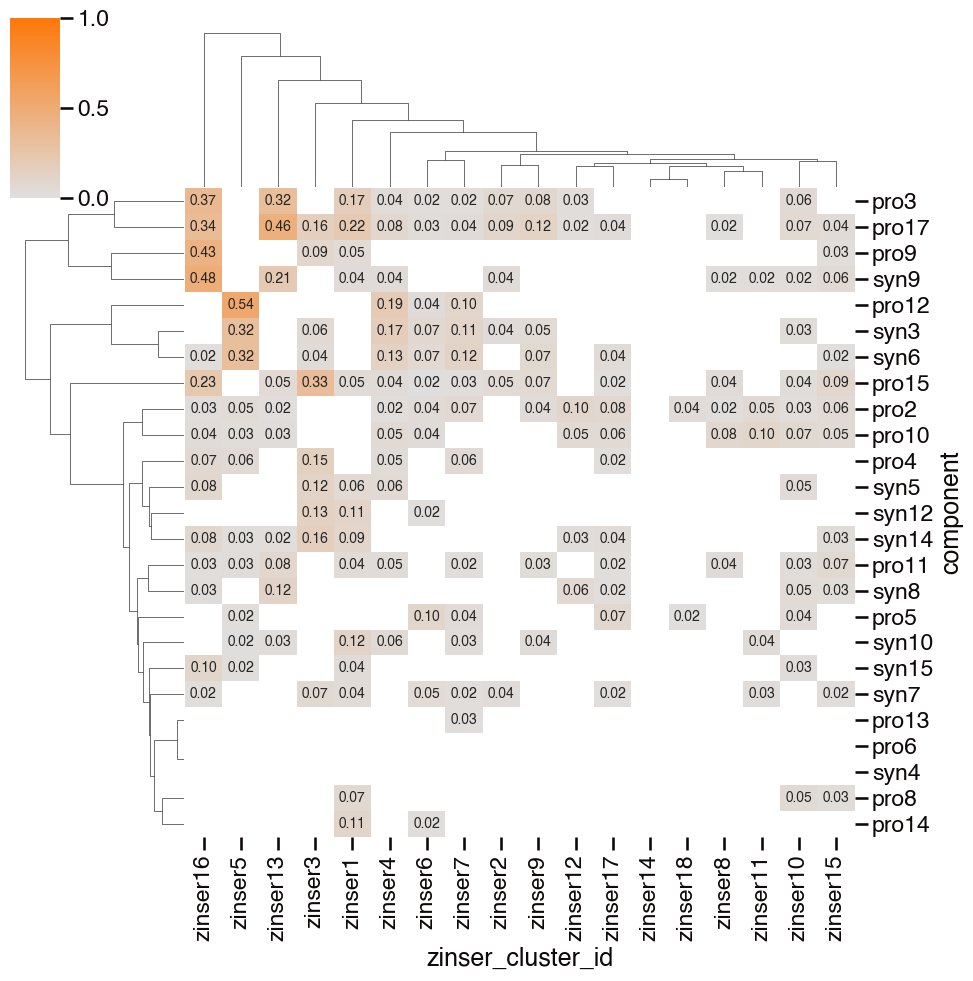

In [10]:
# calculate pairwise weight dice scores

dice_df = pd.DataFrame(index=zinser_scores_df.index, columns=barnacle_boots_df.index, dtype=float)
for zid, zweight in zinser_scores_df.iterrows():
    for bid, bweight in barnacle_boots_df.iterrows():
        # cluster membership is set as the non-zero entries for each vector of scores/bootstraps
        # dice score weights are calculated as the sum of the zinser cluster scores and the barnacle cluster bootstraps
        dice_df.loc[zid, bid] = 1 - dice(zweight.gt(0), bweight.gt(0), w=(zweight+bweight))

# make clustermap
g = sns.clustermap(
    dice_df.T, cmap=cmap, vmin=0, vmax=1, cbar_kws={'shrink': .5}, mask=(dice_df.T==0), 
    yticklabels=True, annot=True, fmt='.2f', annot_kws={'fontsize':10}
); 


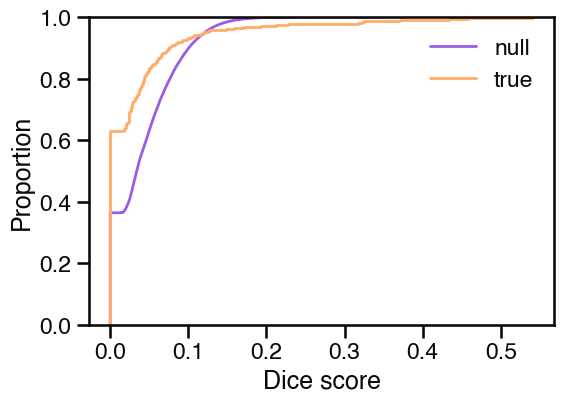

In [11]:
# calculate null dice scores

n_shuffles = 100
seed = 9481
rng = np.random.default_rng(seed)
null_dice = []
for _, zweight in zinser_scores_df.iterrows():
    for _, bweight in barnacle_boots_df.iterrows():
        zshuff = zweight.to_numpy()
        bshuff = bweight.to_numpy()
        for _ in range(n_shuffles):
            # shuffle weight vectors
            rng.shuffle(zshuff)
            rng.shuffle(bshuff)
            # calculate null dice score
            # cluster membership is set as the non-zero entries for each vector of scores/bootstraps
            # dice score weights are calculated as the sum of the zinser cluster scores and the barnacle cluster bootstraps
            null_dice.append(1 - dice(zshuff > 0, bshuff > 0, w=(zshuff+bshuff)))

# plot true scores ecdf over null ecdf
fig, axis = plt.subplots(figsize=(6, 4))
sns.ecdfplot(null_dice, label='null', ax=axis)
sns.ecdfplot(dice_df.values.flatten(), label='true', ax=axis)
axis.set(xlabel='Dice score');
axis.legend();


In [12]:
# calculate empirical p-values for dice scores and look at significant scores

# generate empirical cdf from null dice scores
ecdf = ECDF(null_dice)

# calculate pvalues
pvals = 1 - ecdf(dice_df)

# correct for multiple hypothesis testing 
booleans, corrected_pvals, _, _ = multipletests(pvals.flatten(), method='fdr_bh')

# reconstitute dataframes
pval_df = pd.DataFrame(corrected_pvals.reshape(dice_df.shape), index=dice_df.index, columns=dice_df.columns)
mask_df = pd.DataFrame(booleans.reshape(dice_df.shape), index=dice_df.index, columns=dice_df.columns)

# join dice score
match_df = pval_df[pval_df.lt(0.05)].melt(ignore_index=False).dropna().reset_index().rename(
    columns={'component': 'barnacle_cluster_id', 'value': 'empirical_p-value'})
match_df = pd.merge(
    match_df, 
    dice_df.melt(ignore_index=False).reset_index().rename(columns={'component': 'barnacle_cluster_id', 'value': 'dice_score'}), 
    on=['zinser_cluster_id', 'barnacle_cluster_id'], how='left'
)

# add cluster size info
match_df['zinser_cluster_size'] = match_df['zinser_cluster_id'].map(zinser_scores_df.gt(0).sum(axis=1))
match_df['barnacle_cluster_size'] = match_df['barnacle_cluster_id'].map(barnacle_boots_df.gt(0).sum(axis=1))
match_df['n_shared_genes'] = np.zeros(len(match_df), dtype=int)
for i, row in match_df.iterrows():
    match_df.loc[i, 'n_shared_genes'] = (zinser_scores_df.loc[row['zinser_cluster_id']].gt(0) & 
                                         barnacle_boots_df.loc[row['barnacle_cluster_id']].gt(0)).sum()

# sort
match_df = match_df.sort_values(['zinser_cluster_id', 'barnacle_cluster_id']).reset_index(drop=True)

match_df

,zinser_cluster_id,barnacle_cluster_id,empirical_p-value,dice_score,zinser_cluster_size,barnacle_cluster_size,n_shared_genes
0,zinser1,pro17,0.027500,0.215602,57,76,8
1,zinser13,pro17,0.000000,0.458655,109,76,26
2,zinser13,pro3,0.002000,0.317517,109,47,14
3,zinser13,syn9,0.028462,0.212418,109,46,9
4,zinser16,pro15,0.016364,0.227039,125,29,10
5,zinser16,pro17,0.002000,0.339952,125,76,19
6,zinser16,pro3,0.000000,0.370434,125,47,18
7,zinser16,pro9,0.000000,0.434021,125,22,19
8,zinser16,syn9,0.000000,0.484619,125,46,25
9,zinser3,pro15,0.002000,0.325021,23,29,5


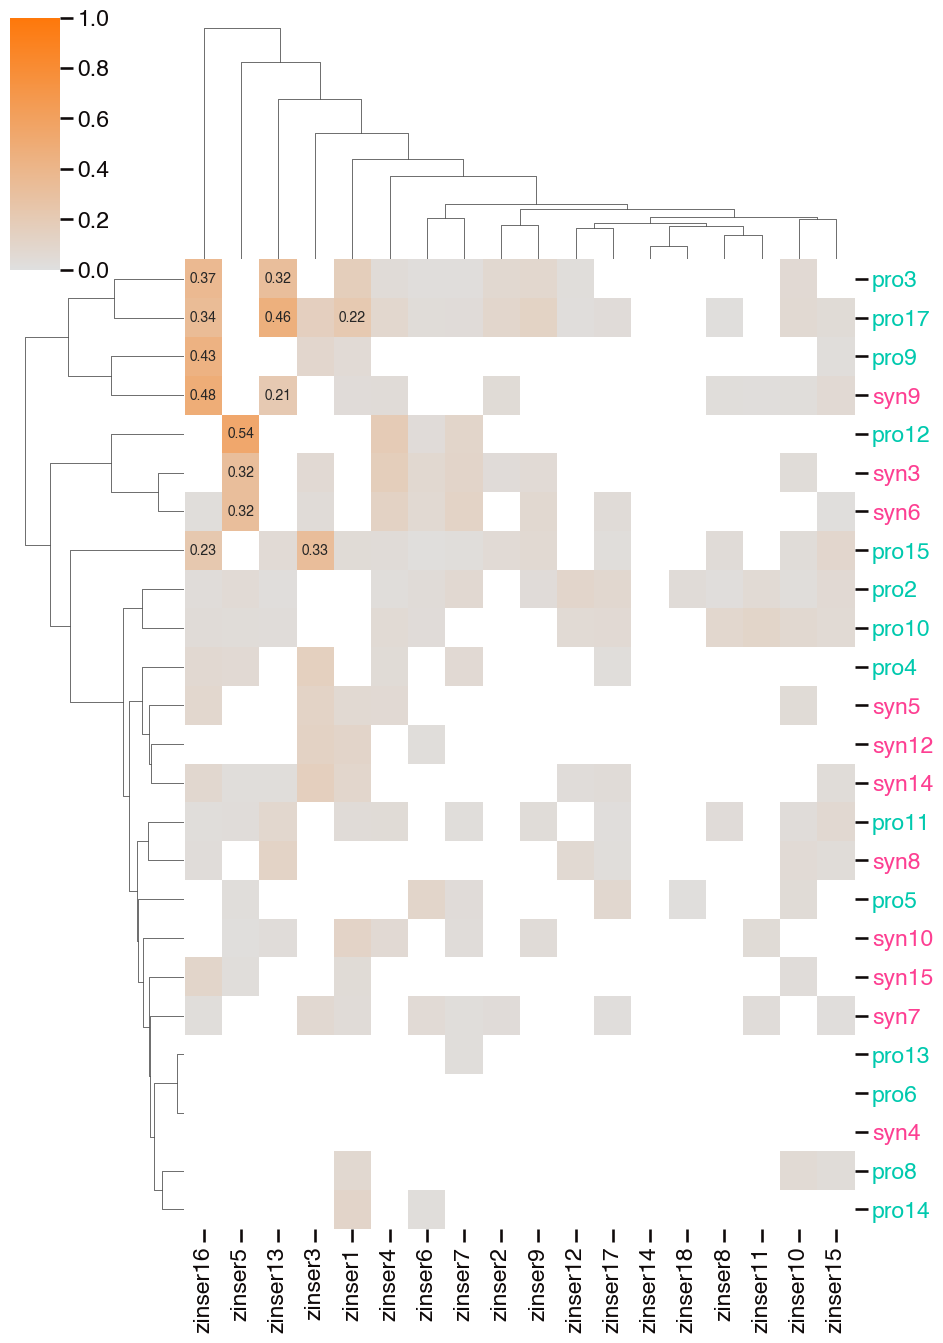

In [13]:
# make nice clustermap plot

# make clustermap
g = sns.clustermap(
    dice_df.T, cmap=cmap, vmin=0, vmax=1, cbar_kws={'shrink': .5}, mask=(dice_df.T==0), 
    yticklabels=True, annot=dice_df.map('{:.2f}'.format)[mask_df].fillna('').T, fmt='', 
    annot_kws={'fontsize':10}, figsize=(10, 14)
)
g.ax_heatmap.set_xlabel(None); 
g.ax_heatmap.set_ylabel(None); 

# color ticks by pro/syn
for tick_axis in [g.ax_heatmap.axes.get_xticklabels(), g.ax_heatmap.axes.get_yticklabels()]: 
    for tick in tick_axis:
        if tick._text in [f'pro{i}' for i in pro_clusters]:
            tick.set_color(sns.color_palette()[2])
        elif tick._text in [f'syn{i}' for i in syn_clusters]:
            tick.set_color(sns.color_palette()[3])

# save figure
g.savefig('zinser-comparison-heatmap.png')


# possible to do:
- add cluster size to labels
- add shared genes as annotation (significant overlaps only)
